# Urban Heat Island (UHI) Benchmark Notebook 

## Challenge Overview

<p align="justify">Welcome to the EY Open Science AI & Data Challenge 2025! The objective of this challenge is to build a machine learning model to predict urban heat island (UHI) hotspots in a city. By the end of the challenge, you will have developed a regression model capable of predicting the intensity of the UHI effect.

Participants will be given ground-level air temperature data in an index format, which was collected on 24th July 2021 on traverse points in the Bronx and Manhattan regions of New York city. This dataset constitutes traverse points (latitude and longitude) and their corresponding UHI (Urban Heat Island) index values. Participants will use this dataset to build a regression model to predict UHI index values for a given set of locations. It is important to understand that the UHI Index at any given location is indicative of the relative temperature elevation at that specific point compared to the city's average temperature.

This challenge is designed for participants with varying skill levels in data science and programming, offering a great opportunity to apply your knowledge and enhance your capabilities in the field.</p>

欢迎参加2025年安永科学人工智能与数据挑战赛！本挑战赛的目标是建立一个机器学习模型来预测城市热岛（UHI）热点。挑战结束时，您将开发出一个能够预测 UHI 效应强度的回归模型。

参赛者将获得2021年7月24日在纽约市布朗克斯区和曼哈顿区穿越点收集的指数格式地面气温数据。该数据集包括穿越点（纬度和经度）及其相应的UHI（城市热岛）指数值。学员将使用该数据集建立一个回归模型，以预测给定地点的UHI指数值。重要的是要明白，任何给定地点的UHI指数都表明了该特定点与城市平均温度相比的相对温度升高。

本挑战赛专为在数据科学和编程方面具有不同技能水平的参赛者设计，为您提供了一个应用所学知识和提高自身能力的绝佳机会。

<b>Challenge Aim: </b><p align="justify"> <p>

<p align="justify">In this notebook, we will demonstrate a basic model workflow that can serve as a starting point for the challenge. The basic model has been constructed to predict the Urban Heat Island (UHI) index using features from the Sentinel-2 satellite dataset as predictor variables. In this demonstration, we utilized three features from the Sentinel-2 dataset: band B01 (Coastal Aerosol), band B06 (Red Edge), and NDVI (Normalized Difference Vegetation Index) derived from bands B04 (Red) and B08 (Near Infrared). A random forest regression model was then trained using these features.
    
These features were extracted from a GeoTIFF image created by the Sentinel-2 sample notebook. For the sample model shown in this notebook, data from a single day (24th July 2021) was considered, assuming that the values of bands B01, B04, B06, and B08 for this specific date are representative of the UHI index behavior at any location. Participants should review the details of the Sentinel-2 sample notebook to gain an understanding of the data and options for modifying the output product. 
    
</p>

<p align="justify">Most of the functions presented in this notebook were adapted from the <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2-Level-2A notebook</a> found in the Planetary Computer portal.</p>

<p align="justify">Please note that this notebook is just a starting point. We have made many assumptions in this notebook that you may think are not best for solving the challenge effectively. You are encouraged to modify these functions, rewrite them, or try an entirely new approach.</p>

在本笔记本中，我们将展示一个基本模型工作流程，作为挑战的起点。基本模型的构建是为了利用哨兵-2卫星数据集的特征作为预测变量来预测城市热岛（UHI）指数。在这次演示中，我们利用了哨兵-2数据集中的三个特征：B01波段（沿海气溶胶）、B06波段（红色边缘）以及从B04波段（红色）和B08波段（近红外）得出的NDVI（归一化差异植被指数）。然后利用这些特征训练随机森林回归模型。

这些特征是从哨兵-2号样本笔记本创建的GeoTIFF图像中提取的。对于本笔记本中显示的样本模型，考虑了单日（2021年7月24日）的数据，假定该特定日期的波段B01、B04、B06和B08值可代表任何地点的UHI指数行为。学员应查看哨兵-2采样笔记本的详细信息，以了解数据和修改输出产品的选项。

本手册中介绍的大部分功能均改编自行星计算机门户网站上的哨兵-2-2A级笔记本。

请注意，本笔记本只是一个起点。我们在本手册中做了许多假设，您可能认为这些假设并不是有效解决挑战的最佳方案。我们鼓励您修改、重写这些函数，或尝试全新的方法。

## Load In Dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows  
from rasterio import features  
from rasterio import warp
from rasterio.warp import transform_bounds 
from rasterio.windows import from_bounds 

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm

## Response Variable

Before building the model, we need to load in the Urban Heat Island (UHI) index training dataset. We have curated data for the New York region. The dataset consists of geo-locations (Longitude and Latitude), with additional fields including date & time of data collection and the UHI index for each location. 
在构建模型之前，我们需要加载城市热岛（UHI）指数训练数据集。我们为纽约地区整理了数据。该数据集由地理位置（经度和纬度）组成，还有其他字段，包括数据收集的日期和时间以及每个位置的UHI指数。

In [2]:
# Load the training data from csv file and display the first few rows to inspect the data
ground_df = pd.read_csv("./Datasets/Target/Training_data_uhi_index.csv")
ground_df.head()

,Longitude,Latitude,datetime,UHI Index
0,-73.919037,40.814292,24-07-2021 15:53,1.034616
1,-73.918978,40.814365,24-07-2021 15:53,1.028125
2,-73.918927,40.814433,24-07-2021 15:53,1.028125
3,-73.918875,40.814500,24-07-2021 15:53,1.025961
4,-73.918827,40.814560,24-07-2021 15:53,1.025961


## Predictor Variables

<p align="justify">Now that we have our UHI data, it is time to gather the predictor variables from the Sentinel-2 dataset. Participants should review the provided Sentinel-2 sample notebook as it was used to create a sample GeoTIFF for this models. For a more in-depth look regarding the Sentinel-2 dataset and how to query it, see the Microsoft Planetary Computer example <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a#Example-Notebook">Sentinel-2 supplementary notebook</a>. </p>

<p align="justify">Sentinel-2 optical data provides high-resolution imagery that is sensitive to land surface characteristics, which are crucial for understanding urban heat dynamics. Band values such as B01 (Coastal aerosol), B06 (Red Edge), and NDVI (Normalized Difference Vegetation Index) derived from B04 (Red) and B08 (Near Infrared) help us in estimating the UHI index. Hence, we are choosing B01, B06, and NDVI as predictor variables for this experiment.</p>

<ul> 
<li>B01 - Reflectance values from the Coastal aerosol band, which help in assessing aerosol presence and improving atmospheric correction.</li>

<li>B06 - Reflectance values from the Red Edge band, which provide useful information for detecting vegetation, water bodies, and urban surfaces.</li>

<li>NDVI - Derived from B04 (Red) and B08 (Near Infrared), NDVI is an important indicator for vegetation health and land cover.</li>
</ul>

现在我们有了UHI数据，是时候从Sentinel-2数据集中收集预测变量了。参与者应查看提供的Sentinel-2示例笔记本，因为它用于为此模型创建示例GeoTIFF。如需更深入地了解Sentinel-2数据集以及如何查询它，请参阅Microsoft Planetary Computer示例Sentinel-2中的补充笔记本。

Sentinel-2光学数据提供了对地表特征敏感的高分辨率图像，这对理解城市热动态至关重要。从B04（红色）和B08（近红外）得出的B01（沿海气溶胶）、B06（红边）和NDVI（归一化植被指数）等波段值有助于我们估算UHI指数。因此，我们选择B01、B06和NDVI作为本实验的预测变量。

<ul> 
<li>B01-沿海气溶胶带的反射率值，有助于评估气溶胶的存在并改善大气校正。</li>

<li>B06-红边带的反射率值，为检测植被、水体和城市表面提供了有用的信息。</li>

<li>NDVI-源自B04（红色）和B08（近红外），NDVI是植被健康和土地覆盖的重要指标。</li>
</ul>

<h4 style="color:rgb(255, 255, 0)"><strong>Tip 1</strong></h4>
<p align="justify">Participants might explore other combinations of bands from the Sentinel-2 and from other satellite datasets as well. For example, you can use mathematical combinations of bands to generate various indices </a> which can then be used as features in your model. These bands or indices may provide insights into surface characteristics, vegetation, or built-up areas that could influence UHI patterns.

参与者可能会探索Sentinel-2和其他卫星数据集中的其他波段组合。例如，您可以使用带的数学组合来生成各种索引，然后这些索引可以用作模型中的特征。这些带或指数可以提供对可能影响UHI模式的地表特征、植被或建成区的见解。

### Analyze the Sentinel-2 Data

<p align="justify">To obtain the Sentinel-2 data, we created a GeoTIFF image for a specific date and area of interest, which in this case is the Bronx and Manhattan regions of New York. The GeoTIFF product allows us to extract the relevant band values. In this example, we extracted B01 (Coastal Aerosol), B04 (Red), B06 (Red Edge), and B08 (Near Infrared) values for a single day (24th July, 2021). Participants should review the provided Sentinel-2 sample notebook for common output images (RGB, NDVI) and methods to alter the output.</p>

为了获得Sentinel-2数据，我们为特定日期和感兴趣的区域创建了一个GeoTIFF图像，在这种情况下是纽约的布朗克斯和曼哈顿地区。GeoTIFF产品允许我们提取相关的带值。在这个例子中，我们提取了一天（2021年7月24日）的B01（沿海气溶胶）、B04（红色）、B06（红色边缘）和B08（近红外）值。参与者应查看提供的Sentinel-2样本笔记本，了解常见的输出图像（RGB、NDVI）和更改输出的方法。

### Methods of Extracting Band Values from Sentinel-2 Data

There are two common methods to extract band values from Sentinel-2 data:

<ul>
    <li><strong>Using API Calls:</strong> Retrieve band values directly from Sentinel-2 datasets via APIs, such as the <code>planetary_computer</code>.</li>
</ul>
<ul>
    <li><strong>Using GeoTIFF Images:</strong> Create and download a GeoTIFF image containing the desired bands and extract the band values locally. The GeoTIFF image can represent any desired time period (single date or time series mosaic) and include any number of spectral bands.</li>
</ul>

Participants can select any of these approaches as per their convenience. Since our dataset is large, the API method can be time-consuming and resource-intensive. Therefore, in this sample notebook, we have opted for the second method and extracted the values for bands B01, B04, B08, and B06. Please refer to the Sentinel-2 sample notebook for details about the creation of the GeoTIFF image. 

从Sentinel-2数据中提取波段值有两种常见方法：

<ul>
    <li><strong>使用API调用：</strong>通过API（如<code>planetary_computer</code>）直接从Sentinel-2数据集检索波段值。</li>
</ul>
<ul>
    <li><strong>使用GeoTIFF图像：</strong>创建并下载包含所需条带的GeoTIFF图片，并在本地提取条带值。GeoTIFF图像可以表示任何所需的时间段（单个日期或时间序列拼接），并包括任何数量的光谱带。</li>
</ul>
参与者可以根据自己的方便选择这些方法中的任何一种。由于我们的数据集很大，API方法可能耗时且资源紧张。因此，在这个示例笔记本中，我们选择了第二种方法，提取了B01、B04、B08和B06波段的值。有关创建GeoTIFF图像的详细信息，请参阅Sentinel-2示例笔记本。

<h4 style="color:rgb(255, 255, 0)"><strong>Tip 2</strong></h4>
<p align="justify"> Rather than extracting the bands for a single day coincident with the ground-based data collection, participants might explore other options to improve data quality. For example, one could select a different single date with minimal or no cloud cover or generate a median mosaic using several scenes within a time series. See the Sentinel-2 sample notebook for examples.</p>

参与者可能会探索其他方法来提高数据质量，而不是在地面数据收集的一天内提取波段。例如，可以选择一个云层覆盖最小或没有云层的不同日期，或者使用时间序列中的几个场景生成中值马赛克。有关示例，请参阅Sentinel-2示例笔记本。

### Downloading GeoTIFF Image

For building a sample model in this demonstration notebook, we have downloaded a GeoTIFF file locally for a single day (24th July 2021). The file is named <b>S2_sample.tiff</b>. This GeoTIFF file contains values of four bands: Band B01, Band B04, Band B06 and Band B08. In the subsequent section, we will use this GeoTIFF file to extract the band values for the geo-locations given in the training dataset to create the features.

First, let’s visualize the bands of the downloaded GeoTIFF image.

为了在这个演示笔记本中构建一个示例模型，我们在本地下载了一个GeoTIFF文件，为期一天（2021年7月24日）。该文件名为<b>S2_sample.tiff</b>。此GeoTIFF文件包含四个波段的值：波段B01、波段B04、波段B06和波段B08。在下一节中，我们将使用此GeoTIFF文件提取训练数据集中给出的地理位置的带值，以创建特征。

首先，让我们可视化下载的GeoTIFF图像的条带。

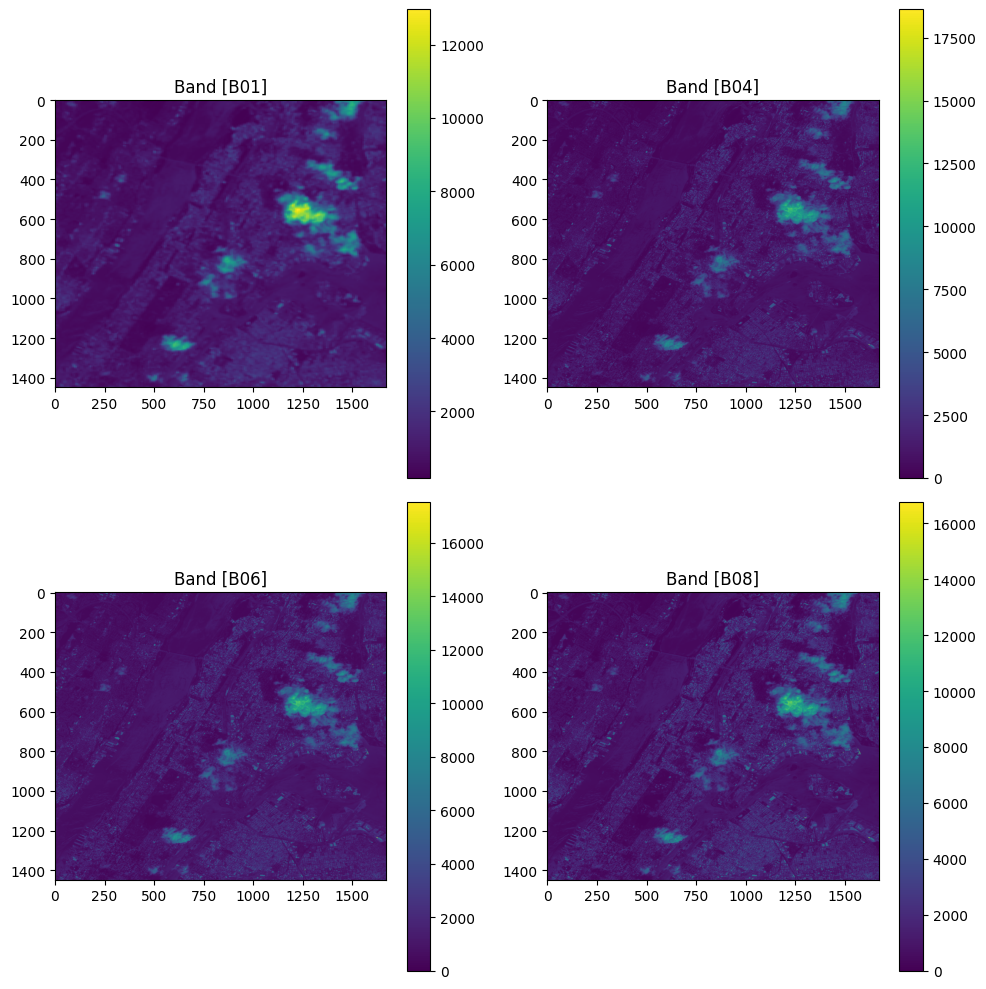

In [3]:
# Reads and plots four bands (B04, B08, B06, B01) from the GeoTIFF file.

# Open the GeoTIFF file
tiff_path = "./Datasets/S2_sample1.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as src1:
    band1 = src1.read(1)  # Band [B01]
    band2 = src1.read(2)  # Band [B04]
    band3 = src1.read(3)  # Band [B06]
    band4 = src1.read(4)  # Band [B08]

# Plot the bands in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes for easier indexing
axes = axes.flatten()

# Plot the first band (B01)
im1 = axes[0].imshow(band1, cmap='viridis')
axes[0].set_title('Band [B01]')
fig.colorbar(im1, ax=axes[0])

# Plot the second band (B04)
im2 = axes[1].imshow(band2, cmap='viridis')
axes[1].set_title('Band [B04]')
fig.colorbar(im2, ax=axes[1])

# Plot the third band (B06)
im3 = axes[2].imshow(band3, cmap='viridis')                 
axes[2].set_title('Band [B06]')
fig.colorbar(im3, ax=axes[2])

# Plot the fourth band (B08)
im4 = axes[3].imshow(band4, cmap='viridis')
axes[3].set_title('Band [B08]')
fig.colorbar(im4, ax=axes[3])

plt.tight_layout()
plt.show()


<h4 style="color:rgb(255, 255, 0)"><strong>Tip 3</strong></h4>

Instead of a single point data extraction, participants might explore the approach of creating a focal buffer around the locations (e.g., 50 m, 100 m, 150 m etc). For example, if the specified distance was 50 m and the specified band was “Band 2”, then the value of the output pixels from this analysis would reflect the average values in band 2 within 50 meters of the specific location. This approach might help reduction in error associated with spatial autocorrelation. In this demonstration notebook, we are extracting the band data for each of the locations without creating a buffer zone.

参与者可以探索在位置周围（例如50米、100米、150米等）创建焦点缓冲区的方法，而不是单点数据提取。例如，如果指定的距离为50米，指定的波段为“波段2”，则此分析的输出像素值将反映特定位置50米范围内波段2中的平均值。这种方法可能有助于减少与空间自相关的误差。在这个演示笔记本中，我们正在提取每个位置的频带数据，而不创建缓冲区。




### Extracting Band Values from the GeoTIFF Image


In [4]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.

def map_satellite_data(tiff_path, csv_path):
    
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)
    
    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    B01_values = []
    B04_values = []
    B06_values = []
    B08_values = []

# Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)
    
        B01_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        B01_values.append(B01_value)
    
        B04_value = data.sel(x=lon, y=lat, band=2, method="nearest").values
        B04_values.append(B04_value)
        
        B06_value = data.sel(x=lon, y=lat, band=3, method="nearest").values
        B06_values.append(B06_value)
    
        B08_value = data.sel(x=lon, y=lat, band=4, method="nearest").values
        B08_values.append(B08_value)

    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df = pd.DataFrame()
    df['B01'] = B01_values
    df['B04'] = B04_values
    df['B06'] = B06_values
    df['B08'] = B08_values
    
    return df

In [5]:
# Mapping satellite data with training data.
final_data = map_satellite_data(tiff_path, './Datasets/Target/Training_data_uhi_index.csv')

Mapping values: 100%|████████████████████| 11269/11269 [00:20<00:00, 562.12it/s]


In [6]:
final_data.head()

,B01,B04,B06,B08
0,1561.0,1390.0,1646.0,1686.0
1,1561.0,1390.0,1646.0,1686.0
2,1502.0,1214.0,1184.0,1408.0
3,1566.0,1286.0,1570.0,1656.0
4,1566.0,1338.0,1390.0,1492.0


In [7]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
# See the Sentinel-2 sample notebook for more information about the NDVI index
final_data['NDVI'] = (final_data['B08'] - final_data['B04']) / (final_data['B08'] + final_data['B04'])
final_data['NDVI'] = final_data['NDVI'].replace([np.inf, -np.inf], np.nan) 

## Joining the predictor variables and response variables
Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function <i><b>combine_two_datasets</b></i> to combine the predictor variables and response variables.The <i><b>concat</b></i> function from pandas comes in handy here.

现在我们已经提取了预测变量，我们需要将它们连接到响应变量上。我们使用函数<i><b>combine_two_datasets</b></i>来组合预测变量和响应变量。pandas的<i><b>concat</b></i>功能在这里很有用。

In [8]:
# Combine two datasets vertically (along columns) using pandas concat function.
def combine_two_datasets(dataset1, dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    
    data = pd.concat([dataset1, dataset2], axis=1)
    return data

In [9]:
# Combining ground data and final data into a single dataset.
uhi_data = combine_two_datasets(ground_df, final_data)
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,B01,B04,B06,B08,NDVI
0,-73.919037,40.814292,24-07-2021 15:53,1.034616,1561.0,1390.0,1646.0,1686.0,0.096229
1,-73.918978,40.814365,24-07-2021 15:53,1.028125,1561.0,1390.0,1646.0,1686.0,0.096229
2,-73.918927,40.814433,24-07-2021 15:53,1.028125,1502.0,1214.0,1184.0,1408.0,0.073989
3,-73.918875,40.814500,24-07-2021 15:53,1.025961,1566.0,1286.0,1570.0,1656.0,0.125765
4,-73.918827,40.814560,24-07-2021 15:53,1.025961,1566.0,1338.0,1390.0,1492.0,0.054417


## Removing duplicates
Identical or duplicate entries are removed based on specific columns, in our case [ 'B01', 'B04', 'B06', 'B08', 'NDVI']. This ensures that the dataset is not biased or skewed by repetitive data, allowing the model to train on unique, relevant observations.

在我们的例子中，根据特定列删除相同或重复的条目[“B01”、“B04”、“B06”、“BO8”、“NDVI”]。这确保了数据集不会因重复数据而产生偏差或偏斜，从而使模型能够根据独特、相关的观察结果进行训练。

In [10]:
# Remove duplicate rows from the DataFrame based on specified columns and keep the first occurrence
columns_to_check = ['B01', 'B04', 'B06', 'B08', 'NDVI']
for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    uhi_data[col] = uhi_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Now remove duplicates
uhi_data = uhi_data.drop_duplicates(subset=columns_to_check, keep='first')
uhi_data.head()

,Longitude,Latitude,datetime,UHI Index,B01,B04,B06,B08,NDVI
0,-73.919037,40.814292,24-07-2021 15:53,1.034616,1561.0,1390.0,1646.0,1686.0,0.096229
2,-73.918927,40.814433,24-07-2021 15:53,1.028125,1502.0,1214.0,1184.0,1408.0,0.073989
3,-73.918875,40.814500,24-07-2021 15:53,1.025961,1566.0,1286.0,1570.0,1656.0,0.125765
4,-73.918827,40.814560,24-07-2021 15:53,1.025961,1566.0,1338.0,1390.0,1492.0,0.054417
5,-73.918785,40.814602,24-07-2021 15:53,1.023798,1566.0,1082.0,1416.0,1476.0,0.154027


In [11]:
# Resetting the index of the dataset
uhi_data = uhi_data.reset_index(drop=True)

## Model Building

<p align="justify"> Now let us select the columns required for our model building exercise. We will consider only Band B01, Band B06 and NDVI from the Sentinel-2 data as our predictor variables. It does not make sense to use latitude and longitude as predictor variables, as they do not have any direct impact on predicting the UHI index.</p>

现在，让我们选择模型构建练习所需的列。我们将仅考虑Sentinel-2数据中的波段B01、波段B06和NDVI作为我们的预测变量。使用纬度和经度作为预测变量是没有意义的，因为它们对预测全民健康指数没有任何直接影响。

In [12]:
# Retaining only the columns for B01, B06, NDVI, and UHI Index in the dataset.
uhi_data = uhi_data[['B01', 'B06', 'NDVI', 'UHI Index']]

### Train and Test Split 

<p align="justify">We will now split the data into 70% training data and 30% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

我们现在将数据分为100%的训练数据和0的测试数据。Scikit-learn别名“sklearn”是Python中用于机器学习的强大库。scikit-learn库有一个model_selection模块，其中有一个拆分函数train_test_split。你可以使用相同的。

In [13]:
# Split the data into features (X) and target (y), and then into training and testing sets
X = uhi_data.drop(columns=['UHI Index']).values
y = uhi_data ['UHI Index'].values

### Feature Scaling 

<p align="justify"> Before initiating the model training we may have to execute different data pre-processing steps. Here we are demonstrating the scaling of B01, B06, NDVI variable by using Standard Scaler.</p>

在开始模型训练之前，我们可能必须执行不同的数据预处理步骤。在这里，我们使用标准定标器演示了B01、B06、NDVI变量的定标。

<p align = "justify">Feature Scaling is a data preprocessing step for numerical features. Many machine learning algorithms like Gradient descent methods, KNN algorithm, linear and logistic regression, etc. require data scaling to produce good results. Scikit learn provides functions that can be used to apply data scaling. Here we are using Standard Scaler. The idea behind Standard Scaler is that it will transform your data such that its distribution will have a mean value 0 and standard deviation of 1.</p>

特征缩放是数值特征的数据预处理步骤。许多机器学习算法，如梯度下降法、KNN算法、线性和逻辑回归等，都需要数据缩放才能产生良好的结果。Scikit-learn提供了可用于应用数据缩放的功能。这里我们使用的是标准定标器。Standard Scaler背后的想法是，它将转换您的数据，使其分布的平均值为0，标准偏差为1。

<h4 style="color:rgb(255, 255, 0)"><strong>Tip 4</strong></h4>
<p align="justify">There are many data preprocessing methods available, which might help to improve the model performance. Participants should explore various suitable preprocessing methods as well as different machine learning algorithms to build a robust model.</p>

有许多数据预处理方法可供选择，这可能有助于提高模型性能。参与者应该探索各种合适的预处理方法以及不同的机器学习算法，以构建一个鲁棒的模型。

In [14]:
# Scale the training and test data using standardscaler
sc = StandardScaler()
X_train = sc.fit_transform(X)

### Model Training

<p align="justify">Now that we have the data in a format suitable for machine learning, we can begin training a model. In this demonstration notebook, we will use a random forest regression model from the scikit-learn library. This library offers a wide range of other models, each with extensive parameter tuning and customization capabilities.</p>

<p align="justify">Scikit-learn models require the separation of predictor variables and the response variable. We will store the predictor variables (Band B01, B06, NDVI) in array X and the response variable (UHI index) in array Y. It is important not to include the response variable in array X. Additionally, since latitude and longitude do not contribute to the prediction of UHI in this case, we will drop those as well.</p>

现在我们有了适合机器学习的数据格式，我们可以开始训练模型了。在本演示笔记本中，我们将使用scikit-learn库中的随机森林回归模型。该库提供了广泛的其他模型，每个模型都具有广泛的参数调整和定制功能。

Scikit学习模型需要分离预测变量和响应变量。我们将把预测变量（波段B01、B06、NDVI）存储在阵列X中，将响应变量（UHI指数）存储在数组Y中。重要的是不要将响应变量包含在数组X中。此外，由于纬度和经度在这种情况下对UHI的预测没有贡献，我们也将删除这些变量。

In [15]:
# Train the Random Forest model on the training data
model = ExtraTreesRegressor()
model.fit(X_train, y)

ExtraTreesRegressor()

## Model Evaluation

<p align="justify">Now that we have trained our model, the next step is to evaluate its performance. For evaluation, we will use the R² score, a common metric for regression models that measures how well the model explains the variance in the response variable (UHI index). Scikit-learn provides many other metrics that can be used for evaluation, and you can also write custom code for more specific evaluation needs.</p>

现在我们已经训练了模型，下一步是评估它的性能。为了进行评估，我们将使用R²评分，这是回归模型的一个常用指标，用于衡量模型对响应变量（UHI指数）方差的解释程度。Scikit-learn提供了许多其他可用于评估的指标，您还可以为更具体的评估需求编写自定义代码。

### In-Sample Evaluation
<p align="justify">We will be evaluating our model's performance using the R² score on the training data. It is important to note that this is in-sample performance testing, which involves evaluating the model on the training dataset. These metrics are not truly indicative of the model's ability to generalize. You should reserve testing on the test data before drawing final conclusions about your model's performance.</p>

我们将使用训练数据上的R²分数来评估模型的性能。值得注意的是，这是样本性能测试，涉及在训练数据集上评估模型。这些指标并不能真正表明模型的泛化能力。在得出关于模型性能的最终结论之前，您应该保留对测试数据的测试。

<p align="justify">In this section, we make predictions on the training set and store them in the <b><i>insample_predictions</i></b> variable. The R² score is then calculated to gauge the model's performance on the training data. It is important to keep in mind that this evaluation is for the training set, and further testing on the test set is necessary to assess the model's generalizability.</p>

在本节中，我们对训练集进行预测，并将其存储在insample_presections变量中。然后计算R²分数，以衡量模型在训练数据上的性能。重要的是要记住，这种评估是针对训练集的，有必要对测试集进行进一步的测试，以评估模型的泛化能力。

In [16]:
# Make predictions on the training data
insample_predictions = model.predict(X_train)

In [17]:
# calculate R-squared score for in-sample predictions
Y_train = y.tolist()
r2_score(Y_train, insample_predictions)

1.0

## Submission

Once you are satisfied with your model, you can proceed to make a submission. To do this, you will need to use your model to predict the Urban Heat Island (UHI) index for a set of test coordinates provided in the <b>"Submission_template.csv"</b> file and upload the results to the challenge platform.

一旦你对你的模型感到满意，你就可以继续提交。为此，您需要使用您的模型来预测“Submission_template.csv”文件中提供的一组测试坐标的城市热岛（UHI）指数，并将结果上传到挑战平台。

In [18]:
# Reading the coordinates for the submission
test_file = pd.read_csv('./Datasets/Supporting_Material/Submission_template.csv')
test_file.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,NaN
1,-73.971928,40.788875,NaN
2,-73.967080,40.789080,NaN
3,-73.972550,40.789082,NaN
4,-73.969697,40.787953,NaN


In [19]:
# Mapping satellite data for submission.
val_data = map_satellite_data(tiff_path, './Datasets/Supporting_Material/Submission_template.csv')

Mapping values: 100%|██████████████████████| 1040/1040 [00:02<00:00, 507.22it/s]


In [20]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
val_data['NDVI'] = (val_data['B08'] - val_data['B04']) / (val_data['B08'] + val_data['B04'])
val_data['NDVI'] = val_data['NDVI'].replace([np.inf, -np.inf], np.nan)  # Replace infinities with NaN

In [21]:
val_data.head()

,B01,B04,B06,B08,NDVI
0,811.0,459.0,617.0,432.0,-0.030303
1,1208.0,562.0,731.0,647.0,0.070306
2,899.0,955.0,1052.0,1188.0,0.108726
3,1193.0,1132.0,1364.0,1512.0,0.143722
4,1097.0,1506.0,1642.0,1688.0,0.056982


In [22]:
# Extracting specific columns (B01, B06, and NDVI) from the validation dataset
submission_val_data = val_data.loc[:, ['B01', 'B06', 'NDVI']]
submission_val_data.head()

,B01,B06,NDVI
0,811.0,617.0,-0.030303
1,1208.0,731.0,0.070306
2,899.0,1052.0,0.108726
3,1193.0,1364.0,0.143722
4,1097.0,1642.0,0.056982


In [23]:
# Feature Scaling 
submission_val_data = submission_val_data.values
transformed_submission_data = sc.transform(submission_val_data)

In [24]:
# Making predictions
final_predictions = model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [25]:
# Combining the results into dataframe
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':final_prediction_series.values})

In [26]:
# Displaying the sample submission dataframe
submission_df.head()

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,0.962733
1,-73.971928,40.788875,0.962733
2,-73.967080,40.789080,0.962613
3,-73.972550,40.789082,0.962733
4,-73.969697,40.787953,0.960449


In [27]:
# Dumping the predictions into a csv file.
submission_df.to_csv("./Datasets/Submissions/submission25.csv", index = False)

### Upload submission file on platform

Upload the submission.csv on the <a href ="https://challenge.ey.com">platform</a> to get score generated on scoreboard.

## Conclusion

<div align ="justify">Now that you have learned a basic approach to model training, it’s time to try your own approach! Feel free to modify any of the functions presented in this notebook. We look forward to seeing your version of the model and the results. Best of luck with the challenge!</div>